In [3]:
 !pip install tenacity

  Using cached tenacity-9.1.2-py3-none-any.whl (28 kB)
You should consider upgrading via the '/Users/sergiovolta/repos/cyt_2025_TP1/venv/bin/python3 -m pip install --upgrade pip' command.


In [4]:
# Para visualización en notebook
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

# Parámetros de visualización
sns.set_context('talk')
mpl.rcParams['figure.figsize'] = (8, 6)


import os
from collections import Counter

# Números y Datos
import numpy as np
import pandas as pd

import networkx as nx
from networkx.algorithms.approximation import average_clustering

from glob import glob
from pathlib import Path

from tenacity import retry

In [97]:
# Definición de Funciones
'''
Permite obtener una Matriz de Adyacencia Pesada (MAP) 
a partir de los datos contenidos en el archivo especificado
Substrae una matriz diagonal de 1s para evitar conexiones 
reflexivas (un nodo consigo mismo)
'''
def obtener_map(nombre_archivo):
    df = pd.read_csv(nombre_archivo, header=None)
    matAdyacPesada = df.values
    n = matAdyacPesada.shape[0]
    matAdyacPesada -= np.diag(np.ones(n))
    return matAdyacPesada

'''
Crea un heatmap a partir de una matriz
'''
def graficar_heatmap(matriz, titulo=''):
    sns.heatmap(matriz)
    n = matriz.shape[0]
    plt.xlim(0, n)
    plt.ylim(0, n)
    plt.title(titulo)
    plt.show()

'''
Exporta un archivo de imagen
de un heatmap obtenido a partir de una matriz
'''
def exportar_heatmap(matriz, nombre_archivo='imagen_01.png'):
    sns.heatmap(matriz)
    n = matriz.shape[0]
    plt.xlim(0, n)
    plt.ylim(0, n)
    plt.savefig(nombre_archivo, dpi=300, bbox_inches='tight')
    plt.close()

'''
Data una matriz de adyacencia pesada y un valor 
de densidad de enlaces, calcula el valor umbral
necesario para representar valores que estén
por encima de la densidad de enlaces dada
'''
def densidad_a_umbral(matriz, densidad=0.1):
    n = matriz.shape[0]
    tril_idx = np.tril_indices(n, -1)
    c = sorted(np.array(list(matriz[tril_idx].reshape(-1))), reverse=True)
    return c[int((len(c)-1)*densidad)]

'''
Permite representar un grafo 
'''
def representar_grafo(G, titulo='', zip_de_layout=None, mostrar_etiquetas=True, nombre_archivo=None):
    plt.figure(figsize=(8, 6))
    plt.title(titulo, fontsize=14)
    nx.draw(G, zip_de_layout, with_labels=mostrar_etiquetas, node_size=25, width=0.1, linewidths=0.25)
    if not nombre_archivo == None:
        plt.savefig(nombre_archivo, dpi=300, bbox_inches='tight')
    plt.show()

'''
Permite representar un grafo a partir de una matriz
de Adyacencia - Agrega una escala de colores para los 
nodos, que refleja el grado
Paletas disponibles: plt.cm.{Grays|Blues|BuGn|PuRd|Oranges}
'''
def representar_grafo_escala_colores(G, escala_color='grados', titulo='', zip_de_layout=None, mostrar_etiquetas=False, nombre_archivo=None):
    if escala_color == 'grados':
        valores_escala = dict(G.degree()) 
    elif escala_color == 'clustering':
        valores_escala = nx.clustering(G)
    nodos = G.nodes()
    n = len(list(nodos))
    n_color = np.asarray([valores_escala[n] for n in nodos])
    vmin = min(n_color)
    vmax = max(n_color)
    cmap = plt.cm.Oranges
    norm = plt.Normalize(vmin = vmin, vmax=vmax)
    plt.figure(figsize=(9,6))
    plt.title(titulo, fontsize=14)
    nx.draw(G, zip_de_layout, node_size=25, edgecolors = 'black', node_color=n_color, width=0.125, linewidths=0.5, vmin=vmin, vmax=vmax,cmap=cmap)
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    plt.colorbar(sm, ax=plt.gca())
    if not nombre_archivo==None:
        plt.savefig(nombre_archivo, dpi=300, bbox_inches='tight')
    plt.show()

'''
En Grafos dirigidos, permite obtener la mayor componente altamente conexa
'''
def obtener_mayor_componente_fuertemente_conexa(G): 
    if nx.is_directed(G):
        StronglyCC = sorted(nx.strongly_connected_components(G), key=len, reverse=True)
        return G.subgraph(StronglyCC[0])
    else:
        return None

    

'''
Calcula el diámetro del Grafo teniendo en cuenta:
    Si la red es no dirigida:
        Si la red es conexa, devuelve el diametro directo
        Si no es conexa devuelve el diámetro de la componente gigante
    Si la red es dirigida:
        Si está fuertemente conectada devuelve el diametro
        Si no está fuertemente conectada, devuelve el diámetro de la mayor componente fuertemente conectada
'''
def calcular_diametro(G):
    if not nx.is_directed(G):
        if nx.is_connected(G):
            print("La red no dirigida y conexa, obteniendo diámetro en forma directa")
            D = nx.diameter(G)
        else:
            print("La red es no dirigida y no es conexa. Retornando el diámetro de la componente gigante.")
            gigante = G.subgraph(max(nx.connected_components(G), key=len)).copy()
            D = nx.diameter(gigante)
    else:
        if nx.is_strongly_connected(G):
            print("La red es dirigida y fuertemente conexa, obteniendo diámetro en forma directa")
            D = nx.diameter(G)
        else:
            largest_scc = max(nx.strongly_connected_components(G), key=len)
            G_scc = G.subgraph(largest_scc).copy()
            print("La red es dirigida y no fuertemente conexa, obteniendo diámetro de la mayor componente fuertemente conexa")
            D = nx.diameter(G_scc)

    return D

'''
Para redes muy grandes, calcula la distancia media por sampleo
tomando n pares de nodos, calculando entre ellos la distancia más
corta y luego promediando.
Utilizo el decorator @retry porque en ciertos ejemplos, uno o más pares de nodos
elegidos pueden no estar conectados y luego su camino no está definido, arrojando 
una excepción. Retry me permite avanzar desestimando el error
'''
@retry
def calcular_distancia_media_y_eff_por_sampleo(G, numero_muestras=100):

    nodos = list(G)
    if numero_muestras > len(nodos):
        numero_muestras = len(nodos)

    if numero_muestras > 100000:
        numero_muestras = 100000
    
    pares = np.random.choice(nodos, (numero_muestras, 2))
    distancias = [nx.shortest_path_length(G, *par)
               for par in pares]
    inversas = [(1/nx.shortest_path_length(G, *par))
               for par in pares]
    return np.mean(distancias), np.mean(inversas)


'''
Devuelve el grado promedio y el nodo con mayor grado
'''
def calcular_grados(matriz, densidad=0.1): 
    G = nx.from_numpy_array(matriz)
    if nx.is_weighted(G):
        umbral = densidad_a_umbral(matriz, densidad)
        G = nx.from_numpy_array(matriz >= umbral)
    else:
        G = nx.from_numpy_array(matriz)
    grados = [G.degree(n) for n in G.nodes()]
    promedio = np.mean(grados)
    nodo_max = max(G.degree(), key=lambda x: x[1])
    return promedio, nodo_max


'''
Calcula grados ponderados 
y grados de entrada y salida 
en grafo dirigido y ponderado
'''
def calcular_grados_dirigido_y_ponderado(G):
    
    # Calcular el grado total ponderado de cada nodo
    grados = dict(G.degree(weight='weight'))

    # Calcular el grado total no ponderado de cada nodo
    grados_nop = dict(G.degree())

    # Encontrar el nodo con mayor grado ponderado
    nodo_max_grado = max(grados, key=grados.get)
    max_grado = grados[nodo_max_grado]
    print(f"Nodo con mayor grado ponderado: {nodo_max_grado} (grado ponderado: {max_grado})")

    # Encontrar el nodo con mayor grado no ponderado
    nodo_max_grado_nop = max(grados_nop, key=grados.get)
    max_grado_nop = grados_nop[nodo_max_grado_nop]
    print(f"Nodo con mayor grado no ponderado: {nodo_max_grado_nop} (grado no ponderado: {max_grado_nop})")
    

    # Grado de entrada ponderado
    grados_entrada = dict(G.in_degree(weight='weight'))
    nodo_max_in = max(grados_entrada, key=grados_entrada.get)
    print(f"Nodo con mayor grado ponderado de entrada: {nodo_max_in} (grado: {grados_entrada[nodo_max_in]})")

    # Grado de entrada no ponderado
    grados_entrada_nop = dict(G.in_degree())
    nodo_max_in_nop = max(grados_entrada_nop, key=grados_entrada_nop.get)
    print(f"Nodo con mayor grado no ponderado de entrada: {nodo_max_in_nop} (grado: {grados_entrada_nop[nodo_max_in_nop]})")

    # Grado de salida ponderado
    grados_salida = dict(G.out_degree(weight='weight'))
    nodo_max_out = max(grados_salida, key=grados_salida.get)
    print(f"Nodo con mayor grado ponderado de salida: {nodo_max_out} (grado: {grados_salida[nodo_max_out]})")

    # Grado de salida ponderado
    grados_salida_nop = dict(G.out_degree())
    nodo_max_out_nop = max(grados_salida_nop, key=grados_salida_nop.get)
    print(f"Nodo con mayor grado no ponderado de salida: {nodo_max_out_nop} (grado: {grados_salida_nop[nodo_max_out_nop]})")
    
    num_nodos = G.number_of_nodes()

    # Grado promedio total Ponderado
    grado_promedio_total = sum(grados.values()) / num_nodos
    print(f"Grado promedio total Ponderado: {grado_promedio_total:.2f}")

    # Grado promedio total No Ponderado
    grado_promedio_total_nop = sum(grados_nop.values()) / num_nodos
    print(f"Grado promedio total No Ponderado: {grado_promedio_total_nop:.2f}")
    
    # Grado promedio de entrada Ponderado
    grado_promedio_in = sum(grados_entrada.values()) / num_nodos
    print(f"Grado promedio de entrada Ponderado: {grado_promedio_in:.2f}")

    # Grado promedio de entrada No Ponderado
    grado_promedio_in_nop = sum(grados_entrada_nop.values()) / num_nodos
    print(f"Grado promedio de entrada No Ponderado: {grado_promedio_in_nop:.2f}")
    

    # Grado promedio de salida Ponderado
    grado_promedio_out = sum(grados_salida.values()) / num_nodos
    print(f"Grado promedio de salida Ponderado: {grado_promedio_out:.2f}")


    # Grado promedio de salida No Ponderado
    grado_promedio_out_nop = sum(grados_salida_nop.values()) / num_nodos
    print(f"Grado promedio de salida No Ponderado: {grado_promedio_out_nop:.2f}")




'''
Analiza y reporta varios parametros de los grafos
'''
def analizar_grafo(G):
    
    print('Es un grafo dirigido?:',nx.is_directed(G))
    print('Es un grafo pesado?:',nx.is_weighted(G))
    if not nx.is_directed(G):
        print('Es un grafo conectado?:',nx.is_connected(G))
    else:
        print('Grafo dirigido no acepta definición de conexo')
    
    diametro = calcular_diametro(G)
    print(f"Diámetro: {diametro}")
    
    if nx.is_directed(G):
        print('Es un grafo fuertemente conexo?:',nx.is_strongly_connected(G))
        print('Es un grafo debilmente conexo?:',nx.is_weakly_connected(G))
        componente_mayor_fuertemente_conexa = obtener_mayor_componente_fuertemente_conexa(G)
        print("Componente mayor fuertemente conexa")
        print(componente_mayor_fuertemente_conexa)
        print(f"Número de nodos en la componente mayor fuertemente conexa: {componente_mayor_fuertemente_conexa.number_of_nodes()}")
        print(f"Número de aristas en la componente mayor fuertemente conexa: {componente_mayor_fuertemente_conexa.number_of_edges()}")        
    else:
        print("Por no ser dirigido no acepta determinación de fuertemente o débilmente conexo")
    
    # Cálculo de distancia media
    if not nx.is_directed(G):
        if nx.is_connected(G):
            distancia_media_directa = nx.average_shortest_path_length(G)
            distancia_media_sampleo, eficiencia_sampleo = calcular_distancia_media_y_eff_por_sampleo(G)
            print(f"Distancia Media del Grafo obtenida por muestreo: {distancia_media_sampleo}")
            print(f"Distancia Media Diecta del Grafo: {distancia_media_directa}")
            print(f"Eficiencia Global Del Grafo obtenida por muestreo: {eficiencia_sampleo}")
        else:
            print("El grafo no es conexo, calculando la distancia media y la eficiencia de la componente gigante")
            print("Esta es una lista de las componentes conexas y su distancia media")
            for componente_nodos in nx.connected_components(G):
                subgrafo = G.subgraph(componente_nodos)
                n = subgrafo.number_of_nodes()
                if nx.is_connected(subgrafo) and n > 1:
                    L = nx.average_shortest_path_length(subgrafo)
                    print(f"- Componente de {n} nodos con distancia media: {L:.3f}")
                #elif n == 1:
                #    print(f"- Componente aislada de 1 nodo (sin distancia definida)")

        
            gigante = G.subgraph(max(nx.connected_components(G), key=len)).copy()
            distancia_media_directa = nx.average_shortest_path_length(gigante)
            nodos_gigante = gigante.number_of_nodes()
            print(f"La componente Gigante tiene {nodos_gigante} nodos")
            eficiencia_directa = nx.global_efficiency(gigante)
            distancia_media_sampleo, eficiencia_sampleo = calcular_distancia_media_y_eff_por_sampleo(gigante) 
            print(f"Distancia Media  de la Componente Gigante obtenida por muestreo: {distancia_media_sampleo}")
            print(f"Distancia Media Directa de la Componente Gigante: {distancia_media_directa}")
            print(f"Eficiencia Global de la Componente Gigante obtenida por muestreo: {eficiencia_sampleo}")    
            print(f"Eficiencia Global Directa de la Componente Gigante: {eficiencia_directa}")
            eficiencia_directa = nx.global_efficiency(G)
            print(f"Eficiencia Global Directa del Grafo: {eficiencia_directa}")
    else:
        if nx.is_strongly_connected(G):
            distancia_media = nx.average_shortest_path_length(G, weight='weight')
            print(f"Distancia media global: {distancia_media}")
        else:
            print("El grafo es dirigido y no es fuertemente conexo; la distancia media no está definida para todos los pares de nodos.")
        # Convertir el grafo dirigido a no dirigido
        print("Transformamos el grafico en no dirigido para calcular la eficiencia global")
        G_no_dirigido = G.to_undirected()
        # Calcular la eficiencia global
        eficiencia_global = nx.global_efficiency(G_no_dirigido)
        print(f"Eficiencia global: {eficiencia_global}")
    
def graficar_distribucion_grados(G, bins=10, titulo='Distribución de Grados', nombre_archivo=None):
    plt.figure(figsize=(6, 4))
    grados = [G.degree(n) for n in G.nodes()]
    hist, bins, _ = plt.hist(grados, bins=bins, density=True)
    plt.xlabel('k')
    plt.ylabel('p(k)')
    plt.title(titulo)
    if not nombre_archivo == None:
        plt.savefig(nombre_archivo, dpi=300, bbox_inches='tight')
    plt.show()

def graficar_distribucion_grados_normalizada(G, bins=10, titulo='Distribución de Grado Normalizada', nombre_archivo=None):
    grados = [G.degree(n) for n in G.nodes()]
    conteo = Counter(grados)
    total_nodos = G.number_of_nodes()
    
    # Crear distribución normalizada
    grados_k = sorted(conteo.keys())
    pk = [conteo[k] / total_nodos for k in grados_k]

    # Graficar
    plt.figure(figsize=(6, 4))
    plt.bar(grados_k, pk, width=0.8, color='skyblue', edgecolor='black')
    #plt.hist(grados_k, bins=bins, density=True)
    plt.xlabel('Grado k')
    plt.ylabel('p(k)')
    plt.title(titulo)
    
    if nombre_archivo:
        plt.savefig(nombre_archivo, dpi=300, bbox_inches='tight')
    
    plt.show()

def read_graph(filename):
    G = nx.Graph()
    array = np.loadtxt(filename, dtype=int)
    G.add_edges_from(array)
    return G

def read_graph_weighted(filename):
    G = nx.Graph()
    array = np.loadtxt(filename, dtype=int)
    G.add_weighted_edges_from(array)
    return G

def read_dir_graph(filename):
    G = nx.DiGraph()
    array = np.loadtxt(filename, dtype=int)
    G.add_edges_from(array)
    return G

def read_dir_graph_weighted(filename):
    G = nx.DiGraph()
    array = np.loadtxt(filename, dtype=int)
    G.add_weighted_edges_from(array)
    return G

'''
Transforma un archivo compuesto por: nodo_partida(espacio)nodo_llegada(espacio)peso
a una matriz de adyacencia cuadrada que se puede analizar
'''
def archivo_edgelist_pesado_a_matriz_adyacencia(archivo_entrada, archivo_salida=None):
    G = read_dir_graph_weighted(archivo_entrada)
    A = nx.to_numpy_array(G, dtype=int, weight='weight')
    return A
    #df = pd.read_csv(archivo_entrada, sep='\s+', header=None, names=['origen', 'destino', 'peso'])    
    #G = nx.from_pandas_edgelist(df, source='origen', target='destino', edge_attr='peso', create_using=nx.DiGraph())
    #matriz_adyacencia = nx.to_pandas_adjacency(G, dtype=int)
    #if archivo_salida is not None:
    #    matriz_adyacencia.to_csv(archivo_salida)
    #return matriz_adyacencia.to_numpy()

    


In [79]:
# Carga de datos
# El archivo de celegans es un archivo de texto separado por espacios vamos a cargarlo en un dataframe para evaluar algunas cosas

df_celegans = pd.read_csv('celegans.txt', sep='\s+', header=None)
matriz_celegans = archivo_edgelist_a_matriz_adyacencia('celegans.txt')

print(f"Shape: {df_celegans.shape}")
print("Primeras filas del archivo")
print(df_celegans.head())
print()
print("Datos de la Primera coordenada")
print(df_celegans.iloc[:,0].describe())
print()
print("Datos de la Segunda coordenada")
print(df_celegans.iloc[:,1].describe())
print()
print("Datos de la Tercera coordenada")
print(df_celegans.iloc[:,2].describe())
print()
print("Datos del Grafo")
G_celegans = read_dir_graph_weighted("celegans.txt")



Shape: (4296, 3)
Primeras filas del archivo
   0  1  2
0  0  1  1
1  0  2  2
2  0  3  1
3  0  4  2
4  0  5  1

Datos de la Primera coordenada
count    4296.000000
mean      117.375233
std        80.035113
min         0.000000
25%        46.000000
50%       114.000000
75%       181.000000
max       296.000000
Name: 0, dtype: float64

Datos de la Segunda coordenada
count    4296.000000
mean      117.375233
std        80.035113
min         0.000000
25%        46.000000
50%       114.000000
75%       181.000000
max       296.000000
Name: 1, dtype: float64

Datos de la Tercera coordenada
count    4296.000000
mean        4.105680
std         5.828476
min         1.000000
25%         1.000000
50%         2.000000
75%         4.000000
max        72.000000
Name: 2, dtype: float64

Datos del Grafo


# Notas
Dado que el archivo de esta red está formado por tripletes, lo entiendo del siguiente modo: 
Primera columna: Nodo de Partida
Segunda Columna: Nodo de llegada
Tercera columna: Fuerza del enlace

# De la literatura

### Estructura General del Conectoma
Número de neuronas: 302 en el hermafrodita adulto.​

### Tipos de neuronas:
- Sensoriales: aproximadamente 90 neuronas que detectan estímulos del entorno.
- Interneuronas: alrededor de 80 neuronas que procesan la información.
- Motoneuronas: aproximadamente 120 neuronas que controlan los músculos.​

### Conexiones:
Sinapsis químicas: alrededor de 5,000.
Uniones gap (eléctricas): aproximadamente 600.
Uniones neuromusculares: alrededor de 2,000

Estas conexiones forman una red dirigida y ponderada, donde las sinapsis químicas y las uniones gap representan diferentes tipos de enlaces entre las neuronas.​

### Propiedades Topológicas de la Red
- Arquitectura de "rich club": Un subconjunto de neuronas altamente conectadas que facilitan la comunicación eficiente en la red.​
- Propiedades de red de "mundo pequeño": Alta agrupación local y cortas distancias promedio entre neuronas, lo que permite una transmisión eficiente de información.​
- Distribución de grado: Algunas neuronas actúan como hubs con un alto número de conexiones, mientras que otras tienen menos conexiones, indicando una distribución heterogénea.​
- Modularidad: La red presenta módulos o comunidades de neuronas que están más densamente conectadas entre sí que con el resto de la red, lo que sugiere una organización funcional.​

Al parecer tenemos una selección parcial del conectoma, dados los números extraídos de la literatura.
Vamos a estudiar las propiedades topológicas para ver si podemos corroborar las características. 



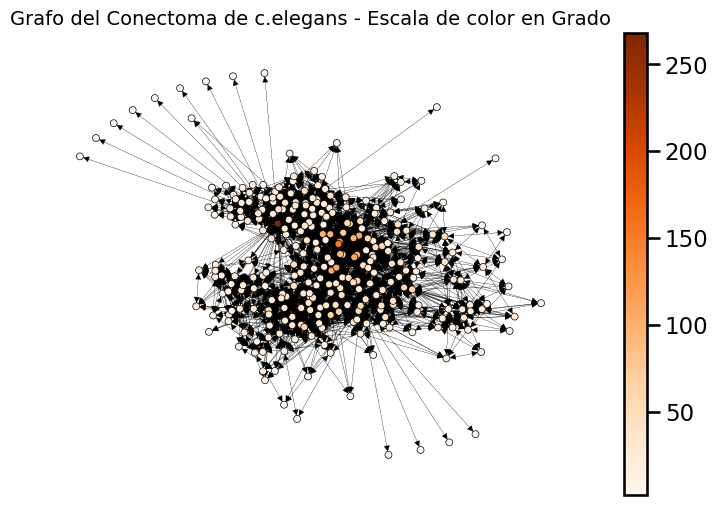

In [80]:
# Representaciones Gráficas

representar_grafo_escala_colores(G_celegans, escala_color='grados', titulo='Grafo del Conectoma de c.elegans - Escala de color en Grado')
#zip_de_layout=None, mostrar_etiquetas=False, nombre_archivo=None)


In [90]:
# Analisis General del Grafo
print("Propiedades del Grafo")
print("---------------------")
analizar_grafo(G_celegans)

Propiedades del Grafo
---------------------
Es un grafo dirigido?: True
Es un grafo pesado?: True
Grafo dirigido no acepta definición de conexo
La red es dirigida y fuertemente conexa, obteniendo diámetro en forma directa
Diámetro: 5
Es un grafo fuertemente conexo?: True
Es un grafo debilmente conexo?: True
Componente mayor fuertemente conexa
DiGraph with 297 nodes and 4296 edges
Número de nodos en la componente mayor fuertemente conexa: 297
Número de aristas en la componente mayor fuertemente conexa: 4296
Distancia media global: 3.8219583219583217
Transformamos el grafico en no dirigido para calcular la eficiencia global
Eficiencia global: 0.4448228531562069


Nodo con mayor grado ponderado: 181 (grado ponderado: 3400)
Nodo con mayor grado no ponderado: 181 (grado no ponderado: 268)
Nodo con mayor grado ponderado de entrada: 181 (grado: 1700)
Nodo con mayor grado no ponderado de entrada: 181 (grado: 134)
Nodo con mayor grado ponderado de salida: 181 (grado: 1700)
Nodo con mayor grado no ponderado de salida: 181 (grado: 134)
Grado promedio total Ponderado: 118.77
Grado promedio total No Ponderado: 28.93
Grado promedio de entrada Ponderado: 59.39
Grado promedio de entrada No Ponderado: 14.46
Grado promedio de salida Ponderado: 59.39
Grado promedio de salida No Ponderado: 14.46

Histogramas de Distribucion de Grados No Ponderados
---------------------------------------------------


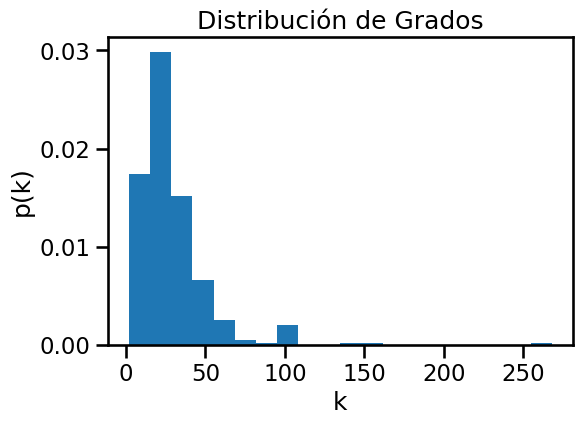

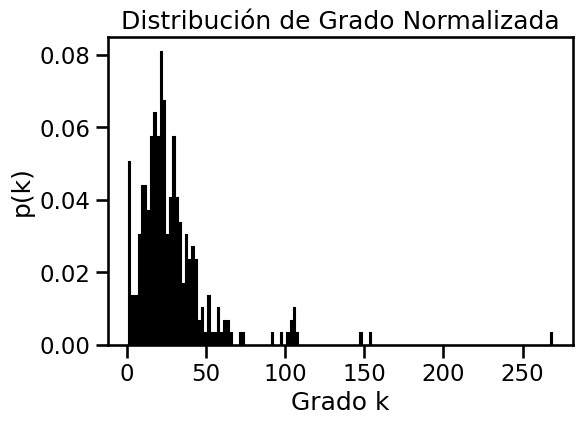

    desde_grado  hasta_grado  número_de_nodos
0             0            9               32
1            10           19               73
2            20           29               82
3            30           39               53
4            40           49               27
5            50           59               10
6            60           69                6
7            70           79                2
8            80           89                0
9            90           99                2
10          100          109                7
11          110          119                0
12          120          129                0
13          130          139                0
14          140          149                1
15          150          159                1
16          160          169                0
17          170          179                0
18          180          189                0
19          190          199                0
20          200          209      

In [104]:
# Distribución de Grado
calcular_grados_dirigido_y_ponderado(G_celegans)
print()
print("Histogramas de Distribucion de Grados No Ponderados")
print("---------------------------------------------------")
graficar_distribucion_grados(G_celegans, bins=20)
graficar_distribucion_grados_normalizada(G_celegans, bins=10)

# Distribución de grados no ponderados en bins
# Grado de entrada (in-degree)
grados_totales = [d for n, d in G_celegans.degree()]
max_grado = max(grados_totales)
bins = np.arange(0, max_grado + 10, 10)

# Calcular el histograma
hist, bin_edges = np.histogram(grados_totales, bins=bins)

# Crear un DataFrame con los resultados
df_histograma = pd.DataFrame({
    'desde_grado': bin_edges[:-1],
    'hasta_grado': bin_edges[1:] - 1,
    'número_de_nodos': hist
})

print(df_histograma)

# Observaciones en la Distribución de Grado
Se observa en las distribuciones sin ponderar que hay 10 nodos con un alto grado (mayor a 100)
Esto es compatible con la distribución que incluye hubs

